<a href="https://colab.research.google.com/github/HermannJoel/Projets-M2DM/blob/main/Text_Mining_TD1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TD-1

In [2]:
# Packages
import pandas as pd
import numpy as np
import json
from zipfile import ZipFile
from pandas import DataFrame
import re
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
np.set_printoptions(precision=3)
import math

In [2]:
# Accès au drive dans lequel se trouvent les données
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### EXERCICE 1: ACQUISITION DES DONNEES

In [3]:
#on dezip le fichier zip contenant les donnéés
zf = ZipFile('/content/drive/MyDrive/dblp.v10.zip', 'r')
zf.extractall('/content/drive/MyDrive/')
zf.close()

In [4]:
json_file_path = "/content/drive/MyDrive/dblp-ref/dblp-ref_0.json"
files = []
for line in open(json_file_path, 'r'):
    files.append(json.loads(line))

In [12]:
#pour afficher les characteristiques de l'article 1
files[0]

{'abstract': 'The purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net- works. More specifically, we focus on the basic principles of network proto- cols as the aim to develop our learning tool. Our tool gives students hands-on experience to help understand the basic principles of network protocols.',
 'authors': ['Makoto Satoh',
  'Ryo Muramatsu',
  'Mizue Kayama',
  'Kazunori Itoh',
  'Masami Hashimoto',
  'Makoto Otani',
  'Michio Shimizu',
  'Masahiko Sugimoto'],
 'id': '00127ee2-cb05-48ce-bc49-9de556b93346',
 'n_citation': 0,
 'references': ['51c7e02e-f5ed-431a-8cf5-f761f266d4be',
  '69b625b9-ebc5-4b60-b385-8a07945f5de9'],
 'title': 'Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map',
 'venue': 'international conference on human-computer interaction',
 'year': 2013}

In [33]:
#effectuer un dum des 100000 premier articles
json.dumps(files[0:100000])

In [131]:
#transformation des 1000000 premiers articles en data-frame
corpus_raw = DataFrame(files[0:100000])
print(corpus_raw.shape)

(100000, 8)


In [132]:
#to remove all "abstract" containing NaN
# creating bool series False for NaN values
bool_series = pd.notnull(corpus_raw["abstract"])
# displayed data only with abstract = NaN
corpus_raw = corpus_raw[bool_series]#To select only articles with an abstract(resumé)
print(corpus_raw.shape)

(39476, 8)


In [134]:
#subsampling by year
corpus_raw = corpus_raw[(corpus_raw.year == 2014) | (corpus_raw.year == 2013) | (corpus_raw.year == 2012)]

In [135]:
print(corpus_raw.shape)
corpus_raw.head()

(15271, 8)


,abstract,authors,n_citation,references,title,venue,year,id
0,The purpose of this study is to develop a lear...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346
10,Recent achievements in Natural Language Proces...,"[Ankita Brahmachari, Priya Singh, Avdhesh Garg...",0,"[84d47128-58d0-4187-aa44-389fde7d5c83, e0dce69...",Identifying Psychological Theme Words from Emo...,,2013,00a119c4-d367-4607-b3c8-b237f2971bff
23,"In recent years, most of mobile phones have a ...","[Hiroshi Furukawa, Yutaka Nakamura]",7,"[b2f0e0d3-0071-4076-921e-f93f30160c1c, f030524...",A pedestrian navigation method for user's safe...,international conference on human computer int...,2013,010d9907-45ef-459a-a293-8e1f41cef2b7
29,Spatial encryption is a generic public-key cry...,"[Michel Abdalla, Jill-Jênn Vie]",50,"[3140c9ba-8d98-42a7-b6b8-c58fdaa8fe75, 4708b4d...",Leakage-Resilient spatial encryption,,2012,016a9a21-e882-4cda-a2b1-b2b46f10601e
34,Business strategy should be well understood in...,"[Constantinos Giannoulis, Jelena Zdravkovic, M...",12,"[0ce446cf-4f4f-49d5-b08c-e7dcacebf53b, 2819d0c...",Model-Driven Strategic Awareness: From a Unifi...,,2012,01b6f2ca-3903-4196-a932-47a4be4c00bf


In [137]:
#select only 3 columns 
cols = ["abstract", "title", "id"]
corpus_raw = corpus_raw[cols]

(15271, 3)


In [142]:
#afficher le corpus final constitué de 15271 lignes (articles) et 3 colonnes 
print(corpus_raw.shape)
corpus_raw.head()

(15271, 3)


,abstract,title,id
0,The purpose of this study is to develop a lear...,Preliminary Design of a Network Protocol Learn...,00127ee2-cb05-48ce-bc49-9de556b93346
10,Recent achievements in Natural Language Proces...,Identifying Psychological Theme Words from Emo...,00a119c4-d367-4607-b3c8-b237f2971bff
23,"In recent years, most of mobile phones have a ...",A pedestrian navigation method for user's safe...,010d9907-45ef-459a-a293-8e1f41cef2b7
29,Spatial encryption is a generic public-key cry...,Leakage-Resilient spatial encryption,016a9a21-e882-4cda-a2b1-b2b46f10601e
34,Business strategy should be well understood in...,Model-Driven Strategic Awareness: From a Unifi...,01b6f2ca-3903-4196-a932-47a4be4c00bf


In [143]:
#to export our data frame into a csv file 
corpus_raw.to_csv("/content/drive/MyDrive/data-TD1", index=False)

### EXERCICE 2: CONSTRUCTION INDEX SUR LES MOTS

In [3]:
corpus = pd.read_csv("/content/drive/MyDrive/data-TD1")

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
from nltk.stem import WordNetLemmatizer 
#instantiate the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [7]:
#to print the unpreprocessed abstract 1
corpus.abstract[0]

'The purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net- works. More specifically, we focus on the basic principles of network proto- cols as the aim to develop our learning tool. Our tool gives students hands-on experience to help understand the basic principles of network protocols.'

In [8]:
%%time
#To create a loop to successively remove characters as punctuation, parentheses... and keep only upper & lower letters characters 
#convert all uppercase letters to lower case
#tokenize the text
#stemm the words
#lemmatization    
corpus_prep = []
for i in range(0, corpus.abstract.shape[0]):
  abstract = re.sub("[^a-zA-Z]", " ", corpus["abstract"][i])#To keep anly all characters letters between lower a-z and upper A to Z
  abstract = abstract.lower()#to convert all upper case letters into lower case letters
  abstract = nltk.word_tokenize(abstract)#to split a sentence into a list of words to loop throught it
  stemmer_en = SnowballStemmer("english")#to apply stemming
  abstract = [stemmer_en.stem(word) for word in abstract if not word in set(stopwords.words("english"))]#to remove all english stopwords(mots utiles) 
  abstract = " ".join([lemmatizer.lemmatize(word) for word in abstract])#To apply lemmatization
  corpus_prep.append(abstract)

CPU times: user 4min 57s, sys: 24.4 s, total: 5min 21s
Wall time: 5min 21s


In [9]:
#print preprocessed abstract 1(stemming & lemmatization)
corpus_prep[0]

'purpos studi develop learn tool high school student studi scientif aspect inform communic net work specif focus basic principl network proto col aim develop learn tool tool give student hand experi help understand basic principl network protocol'

In [10]:
#to concatenate the preprocessed abstract with titles and id
Columns_to_keep = ["title", "id"]
df = corpus[Columns_to_keep]
corpus_abstract = DataFrame(corpus_prep, columns=["abstract"])
corpus = pd.concat([corpus_abstract, df], axis=1)

In [11]:
corpus.head()

,abstract,title,id
0,purpos studi develop learn tool high school st...,Preliminary Design of a Network Protocol Learn...,00127ee2-cb05-48ce-bc49-9de556b93346
1,recent achiev natur languag process nlp psycho...,Identifying Psychological Theme Words from Emo...,00a119c4-d367-4607-b3c8-b237f2971bff
2,recent year mobil phone function pedestrian na...,A pedestrian navigation method for user's safe...,010d9907-45ef-459a-a293-8e1f41cef2b7
3,spatial encrypt generic public key cryptosyste...,Leakage-Resilient spatial encryption,016a9a21-e882-4cda-a2b1-b2b46f10601e
4,busi strategi well understood order support en...,Model-Driven Strategic Awareness: From a Unifi...,01b6f2ca-3903-4196-a932-47a4be4c00bf


### PONDERATION TF & TF-IDF

#### TF

In [12]:
#instantiate and fit the vectorizer tf to obtain a
#parse matrix of entire corpus with shape documents*termes
tf_Vectorizer = CountVectorizer().fit(corpus["abstract"])
tf_bagof_words = tf_Vectorizer.transform(corpus["abstract"])
print("The shape of sparse matrix using TF vectorizer is: ", tf_bagof_words.shape)

The shape of sparse matrix using TF vectorizer is:  (15271, 30182)


#### TF-IDF

In [13]:
#instantiate and fit the vectorizer tfidf
tfidf_Vectorizer = TfidfVectorizer().fit(corpus["abstract"])
tfidf_bagof_words = tfidf_Vectorizer.transform(corpus["abstract"])
print("The shape of sparse matrix using TF-idf vectorizer is: ", tfidf_bagof_words.shape)

The shape of sparse matrix using TF-idf vectorizer is:  (15271, 30182)


In [14]:
#check the total number of vocabulary words in document 24 (abstract 24)
#to print abstract number 24
abstract_24 = corpus["abstract"][23]
print(abstract_24)
bow_24 = tfidf_Vectorizer.transform([abstract_24])

introduc data music novel approach aid analysi understand sleep measur data data music process automat compos novel music given data use guid process present sleep music methodolog read signal state art mattress sensor use high non trivial data analysi method measur sleep signal compos music measur result sleep music produc music reflect user sleep night complement visual sleep measur ultim goal help user improv sleep well practic use later evalu methodolog built public web servic http sleepmusic net user sleep sensor


In [15]:
#sparse matrix of shape 1x30182 (1 times the entire vocabulary size)
print(bow_24.shape)

(1, 30182)


In [16]:
#weight value of each words in document 24 vs the entire document
print(bow_24)

  (0, 29417)	0.034419590837390074
  (0, 29327)	0.04361423566397409
  (0, 28965)	0.04606834643503866
  (0, 28423)	0.09882675551495682
  (0, 28416)	0.05458376700398799
  (0, 27955)	0.04459313428990705
  (0, 27757)	0.07244795644535763
  (0, 27382)	0.06876891971842587
  (0, 25030)	0.03795523384027896
  (0, 24211)	0.11676291409151136
  (0, 24210)	0.7276340120126715
  (0, 23966)	0.10492163188898167
  (0, 23647)	0.041861697382050665
  (0, 23565)	0.10119501681541451
  (0, 22326)	0.022806347088565982
  (0, 21961)	0.05647227713139103
  (0, 21733)	0.06261186985932908
  (0, 21155)	0.0503274728705636
  (0, 20833)	0.04861106607310533
  (0, 20816)	0.05913794818314905
  (0, 20660)	0.024770182809225057
  (0, 20504)	0.04211409275129574
  (0, 18037)	0.07660830286350484
  (0, 17879)	0.040912297267387716
  (0, 17745)	0.09309580571079003
  (0, 17563)	0.06345988955615942
  (0, 17184)	0.490122218686577
  (0, 16096)	0.09984757909835432
  (0, 16088)	0.026729014764382823
  (0, 15809)	0.15786615594503903
  (0, 15

In [17]:
#to check the word with an index number 17184 with a weight value of 0.49 in abstract 24 
tfidf_Vectorizer.get_feature_names_out()[17184]

'music'

#### Mots les plus frequents

In [18]:
def top_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids if row[i]>0]
    df = pd.DataFrame(top_feats)
    if len(top_feats) > 0:
        df.columns = ['features', 'score']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_feats(row, features, top_n)

In [19]:
#
features_tfidf = tfidf_Vectorizer.get_feature_names()
features_tf = tf_Vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15,8)})

In [21]:
#most frequent word in abstract 1 (index 0) vectorizer tf
top_feats_in_doc(tf_bagof_words, features_tf, 0, top_n=10)

,features,score
0,tool,3
1,learn,2
2,develop,2
3,studi,2
4,principl,2
5,network,2
6,student,2
7,basic,2
8,help,1
9,experi,1


In [22]:
#construction du data frame contenant les mots les plus fréquents du vocabulaire
Data_tf = tf_bagof_words.toarray()
n_docs, n_terms = Data_tf.shape
tf_sum = np.sum(Data_tf, axis=0)
df_plot = top_feats(tf_sum, features_tf)
df_plot

,features,score
0,use,16002
1,model,11522
2,system,10596
3,base,10561
4,paper,9650
5,data,9238
6,propos,8942
7,method,8073
8,result,7674
9,algorithm,7395


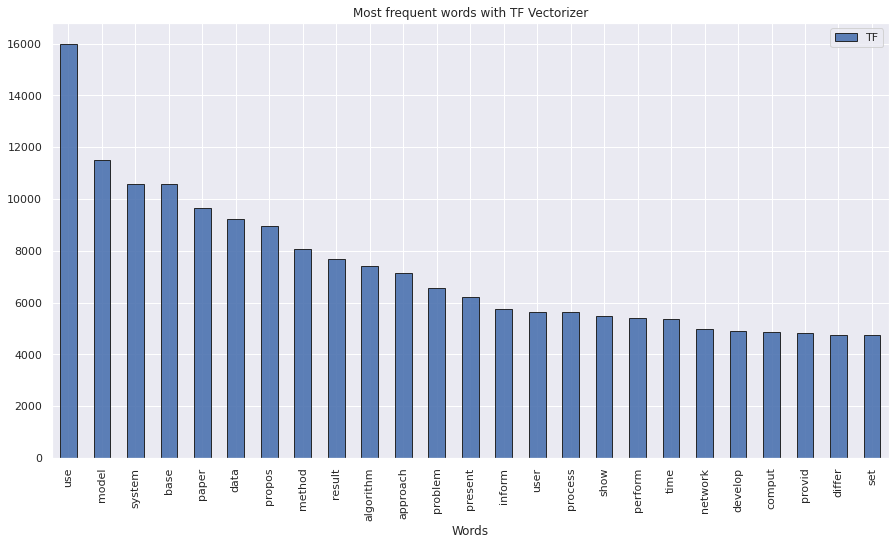

In [23]:
#Visualisation des mots les plus fréquents
top_f = df_plot.features
top_v = df_plot.score
DF = pd.DataFrame({'Words':top_f, 'TF':top_v})
DF.plot.bar(x='Words', y='TF', rot=90, color="b", alpha=0.9, edgecolor='k', linewidth=1, 
            title ="Most frequent words with TF Vectorizer");

Avec le vectorizer TF, le mot le plus frequent du vocabulaire est `use` avec 16002 occurences ensuite `model` avec 11522.


## EXERCICE 3: MISE EN PLACE MOTEUR DE RECHERCHE
 Les calculs sont effectués pour cette sous-section en utilisant le ponderateur TF

In [24]:
# function to compute the cosinus between 2 vectors
def cosinus(i, j):
    num = np.dot(i, j)
    den = math.sqrt(sum(i*i))*math.sqrt(sum(j*j))
    if (den>0):    
        return (num/den)
    else:
        return 0

1. formuler une requête sous la forme d’une liste de mots

In [28]:
#query as a list of words
query_tf = ["use", "model", "system", "base"]
indexes_tf = [features_tf.index(q) for q in query_tf if q in features_tf]
print(indexes_tf)

[28416, 16595, 25888, 2177]


2. construire un pseudo-document correspondant à la requête, c.a.d un vecteur-requête dans le même espace que les documents(abstracts)

In [29]:
#we build a vector of same size as the vocabulary. int it to 0, 
#then set the value of the request terms to 1. with n_terms=30182
query_vec_tf = np.zeros(n_terms)
query_vec_tf[indexes_tf] = 1

3.4. Fonction qui permet de comparer le vecteur-requête avec tous les vecteurs documents (c.a.d les lignes de la matrice). Ensuite range le vecteur des scores par ordre decroissant. 

In [30]:
# fonction qui crée un dictionnaire associant le cosinus à chaque documents(abstract)
# puis effectue un tri de manière décroissante
def search(q, Data):
    cc = {i: cosinus(Data[i, :], q) for i in range(n_docs)}
    cc = sorted(cc.items(), key=lambda x: x[1], reverse=True)
    return cc

In [31]:
%%time
result_tf = search(query_vec_tf, Data_tf)

CPU times: user 6min 22s, sys: 4min 58s, total: 11min 20s
Wall time: 5min 47s


5. Afficher les documents qui ont obtenu les meilleurs scores.


In [32]:
#pour afficher les 5 premiers resultats
result_tf[0:5]

[(4508, 0.6249324287797365),
 (3160, 0.6240377207533828),
 (3533, 0.5922801330182954),
 (7490, 0.5756926422568069),
 (13385, 0.5640760748177662)]

In [33]:
nb_top_docs = 5
top_docs = [r for (r,v) in result_tf[0:nb_top_docs]]
print(top_docs)

[4508, 3160, 3533, 7490, 13385]


In [34]:
#pour afficher les documents avec les 5 meilleurs scores
for i, td in zip(range(nb_top_docs), top_docs):
    print("%s (%s): %s" % (i+1, td, corpus.abstract[td]))

1 (4508): simul becom indispens tool research explor system without recours real experi depend characterist model system method use repres system may vari multi agent system thus often use model simul complex system whatev model type use increas size precis model increas amount comput requir use parallel system becom larg paper focus parallel platform support multi agent simul contribut survey exist platform evalu context high perform comput present qualit analysi main base platform properti perform comparison use agent model implement platform
2 (3160): simul base design develop servic base softwar system sb import analyz model correct improv confid valid model particular interest sb simul model use toward evalu time depend qos metric e g servic delay throughput etc paper experi base valid servic base softwar system use soc dev e servic orient comput dev framework present formal basi toward valid real system consider abstract dev system model experi develop observ time base trajectori

# EXPERIENCES

b) Changer la taille du vocabulaire. utiliser les 500 mots les plus frequents ainsi que 5000 mots choisis alleatoirement

In [39]:
def top_feats(row, features, top_n=500):#n=500 to chose the 500 most ferquent words
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids if row[i]>0]
    df = pd.DataFrame(top_feats)
    if len(top_feats) > 0:
        df.columns = ['features', 'score']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=500):
    ''' Top features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_feats(row, features, top_n)

In [40]:
#chose the 500 most frequent words in the dictionnary
most_fw_500 = tf_bagof_words.toarray()
n_docs, n_terms = most_fw_500.shape
tf_sum = np.sum(most_fw_500, axis=0)
df_plot = top_feats(tf_sum, features_tf)

In [78]:
#construct a bag of words with 5000 randomnly chosen documents
tf_Vectorizer_5000 = CountVectorizer().fit(corpus["abstract"].sample(n=5000))
tf_bagof_words_5000 = tf_Vectorizer_5000.transform(corpus["abstract"].sample(n=5000))
print("The shape of sparse matrix of 5000 documents is: ", tf_bagof_words_5000.shape)

The shape of sparse matrix of 5000 documents is:  (5000, 16375)


In [79]:
#creé une liste qui contient les 5000 mots du dictionnaire 
features_tf_5000 = tf_Vectorizer_5000.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
#to create a query vector containing the 500 most frequents words
query_500 = []
for i in range(0, df_plot.shape[0]):
  word = df_plot["features"][i]
  query_500.append(word)

In [91]:
#afficher la requête contenant les 500 mots les plus fréquents
np.transpose(query_500[0:100])

array(['use', 'model', 'system', 'base', 'paper', 'data', 'propos',
       'method', 'result', 'algorithm', 'approach', 'problem', 'present',
       'inform', 'user', 'process', 'show', 'perform', 'time', 'network',
       'develop', 'comput', 'provid', 'differ', 'set', 'studi', 'applic',
       'design', 'new', 'two', 'imag', 'learn', 'also', 'one', 'evalu',
       'work', 'featur', 'analysi', 'research', 'effect', 'improv',
       'techniqu', 'function', 'requir', 'object', 'optim', 'servic',
       'experi', 'relat', 'effici', 'order', 'structur', 'number',
       'implement', 'task', 'high', 'framework', 'howev', 'support',
       'well', 'detect', 'test', 'case', 'complex', 'generat', 'real',
       'first', 'level', 'compar', 'control', 'interact', 'exist',
       'specif', 'knowledg', 'languag', 'measur', 'larg', 'import',
       'state', 'appli', 'oper', 'allow', 'tool', 'search', 'solut',
       'consid', 'mani', 'need', 'graph', 'increas', 'introduc',
       'program', 'softw

In [80]:
#pour verifier les indexes des 500 mots les plus frequents dans nos 5000 documents choisi alleatoirement 
indexes_500 = [features_tf_5000.index(q) for q in query_500 if q in features_tf_5000]
print(indexes_500[0:20])

[15465, 9023, 14076, 1173, 10362, 3218, 11373, 8759, 12150, 383, 722, 11281, 11189, 6968, 15470, 11295, 12982, 10605, 14580, 9545]


In [81]:
#we build a vector of same size as the vocabulary. int it to 0, 
#then set the value of the request terms to 1. with n_terms=30182
query_vec_500 = np.zeros(n_terms)
query_vec_500[indexes_500] = 1

In [82]:
%%time
result_500 = search(query_vec_500, most_fw_500)

CPU times: user 6min 28s, sys: 4min 55s, total: 11min 23s
Wall time: 5min 48s


In [84]:
#pour afficher les 5 premiers resultats
result_500[0:5]

[(12038, 0.03905498468561694),
 (3741, 0.03872983346207417),
 (4319, 0.03859055284950928),
 (9801, 0.037546718865447824),
 (3691, 0.03632696097723621)]

In [85]:
nb_top_docs = 5
top_docs = [r for (r,v) in result_500[0:nb_top_docs]]
print(top_docs)

[12038, 3741, 4319, 9801, 3691]


In [86]:
#pour afficher les documents avec les 5 meilleurs scores
for i, td in zip(range(nb_top_docs), top_docs):
    print("%s (%s): %s" % (i+1, td, corpus.abstract[td]))

1 (12038): paper bimanu gestur interfac use data glove present build upon past contribut gestur interfac bimanu interact creat effici intuit gestur interfac use wide varieti immers virtual environ base real world biman ual interact propos interfac use hand asymmetr style left hand provid mode interact right hand act finer level detail valid effici interfac design compar ativ studi propos two hand interfac one hand variant conduct group right hand user result experi support bimanu interfac effici unimanu one ex pect interfac conclus drawn experi use guid effici design futur bimanu gestur interfac
2 (3741): review deegan marilyn mccarthi willard ed collabor research digit human farnham ashgat
3 (4319): deliv negat perform feedback inevit workplac howev recipi may feel uncomfort behav defens may unwil accept negat feedback main fear lose face unproduct respons heighten negat feedback deliv comput mediat communic cmc channel mani nonverb cue face face communic use allevi concern lose face 

On constate une plus forte occurances des mots les plus frequents comme `use` et `model` lorsqu'on reduit la taille du dictonnaire

a) Changer le schema de ponderation. Vectorizer TF-IDF

In [96]:
#instantiate and fit the vectorizer tfidf
tfidf_Vectorizer = TfidfVectorizer().fit(corpus["abstract"])
tfidf_bagof_words = tfidf_Vectorizer.transform(corpus["abstract"])
Data_tfidf = tfidf_bagof_words.toarray()
print("The shape of sparse matrix using TF-idf vectorizer is: ", tfidf_bagof_words.shape)

The shape of sparse matrix using TF-idf vectorizer is:  (15271, 30182)


In [94]:
#query as a list of words
query = ["use", "model", "system", "base"]
indexes_tfidf = [features_tfidf.index(q) for q in query if q in features_tfidf]
print(indexes_tfidf)

[28416, 16595, 25888, 2177]


In [95]:
#we build a vector of same size as the vocabulary. int it to 0, 
#then set the value of the request terms to 1. with n_terms=30182
query_vec_tfidf = np.zeros(n_terms)
query_vec_tfidf[indexes_tfidf] = 1

In [98]:
result_tfidf = search(query_vec_tfidf, Data_tfidf)

In [99]:
result_tfidf[0:5]

[(7490, 0.40018864637669005),
 (4508, 0.3861384871746192),
 (3160, 0.3353657137601395),
 (12041, 0.3235424904102695),
 (13585, 0.3157156824863251)]

In [101]:
nb_top_docs = 5
top_docs = [r for (r,v) in result_tfidf[0:nb_top_docs]]
print(top_docs)

[7490, 4508, 3160, 12041, 13585]


In [35]:
#pour afficher les documents (abtracts) les plus pertinents pour la requête. Methode de ponderation TF
for i, td in zip(range(nb_top_docs), top_docs):
    print("%s (%s): %s" % (i+1, td, corpus.abstract[td]))

1 (4508): simul becom indispens tool research explor system without recours real experi depend characterist model system method use repres system may vari multi agent system thus often use model simul complex system whatev model type use increas size precis model increas amount comput requir use parallel system becom larg paper focus parallel platform support multi agent simul contribut survey exist platform evalu context high perform comput present qualit analysi main base platform properti perform comparison use agent model implement platform
2 (3160): simul base design develop servic base softwar system sb import analyz model correct improv confid valid model particular interest sb simul model use toward evalu time depend qos metric e g servic delay throughput etc paper experi base valid servic base softwar system use soc dev e servic orient comput dev framework present formal basi toward valid real system consider abstract dev system model experi develop observ time base trajectori

In [102]:
#pour afficher les documents(abtracts) les plus pertinents pour la requête. Methode de ponderation TF-IDF
for i, td in zip(range(nb_top_docs), top_docs):
    print("%s (%s): %s" % (i+1, td, corpus.abstract[td]))

1 (7490): cope grow complex embed system design sever develop approach propos popular use model main artifact construct maintain want role model ea systemat standard approach construct softwar base system order enforc reus interconnect process model specif system develop model promot model base approach coupl repositori model paper propos model driven engin methodolog approach develop repositori model oper architectur develop tool particular show feasibl approach report preliminari prototyp provid model base repositori secur depend pattern model
2 (4508): simul becom indispens tool research explor system without recours real experi depend characterist model system method use repres system may vari multi agent system thus often use model simul complex system whatev model type use increas size precis model increas amount comput requir use parallel system becom larg paper focus parallel platform support multi agent simul contribut survey exist platform evalu context high perform comput pr

On note une légère difference dans l'ordre d'appartion des textes les plus pertinents pour une requête contenant les mêmes mots lorsque nous changeons la methode de ponderation. Nous pouvons neanmoins constaté que les deux méthodes renvoient des documents senblables. 